## Task 1: Introduction


Starter notebook for the Coursera Guided Project [Creating Multi Task Models With Keras]

In [1]:
%matplotlib inline
%load_ext tensorboard

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil

try:
  shutil.rmtree('logs')
except:
  pass

2022-09-29 17:11:56.794345: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 17:11:57.715570: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-29 17:12:01.526036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-09-29 17:12:01.526412: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## Task 2: Create Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
print("x_train -> ","size :",x_train.size, "| shape :",x_train.shape)
print("x_test  -> ","size :",x_test.size, "| shape :",x_test.shape)
print("y_train -> ","size :",y_train.size, "| shape :",y_train.shape)
print("y_test  -> ","size :",y_test.size, "| shape :",y_test.shape)

x_train ->  size : 47040000 | shape : (60000, 28, 28)
x_test  ->  size : 7840000 | shape : (10000, 28, 28)
y_train ->  size : 60000 | shape : (60000,)
y_test  ->  size : 10000 | shape : (10000,)


In [4]:
def create_example(x, y):
    # Defining Color label
    c = np.random.randint(0, 2) # Taking 0 or 1 as a random input

    # Converting B/W MNIST image to Red or Green Color Dominant Image
    image = 0.5 * np.random.rand(28, 28, 3) # 28x28 is image resolution and 3 is color attribute
    image[:, :, c] += 0.5 * x/255 # Adding Normalized Color attribute to MNIST image 
    return image, y, c

Digit : 3
Color : red


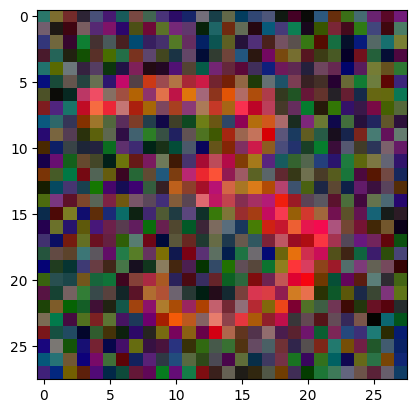

In [5]:
colors = {0 : "red", 1 : "green"}

x, y, c = create_example(x_train[12], y_train[12])
print("Digit :",y)
print("Color :",colors[c])

plt.imshow(x)
plt.show()

## Task 3: Dataset Generator

In [6]:
# Generator to be used for training and testing
# Default batch_size = 32
def generate_data(x, y, batch_size=32):
    # Total numbers of examples
    num_examples = len(y)

    while True:
        x_batch = np.zeros((batch_size, 28, 28, 3)) # Current shape of images after adding noise
        y_batch = np.zeros((batch_size,)) # y values will be in range of [0-9]
        c_batch = np.zeros((batch_size,)) # c values will be in range of [0-1] --> Color Values

        for i in range(0, batch_size):
            # Taking a random index/ example
            index = np.random.randint(0, num_examples)
            image, digit, color = create_example(x[index], y[index])
            x_batch[i] = image
            y_batch[i] = digit
            c_batch[i] = color
        
        # YIELD --> returns single item in a list after processed
        yield x_batch, [y_batch, c_batch]

[4.] green


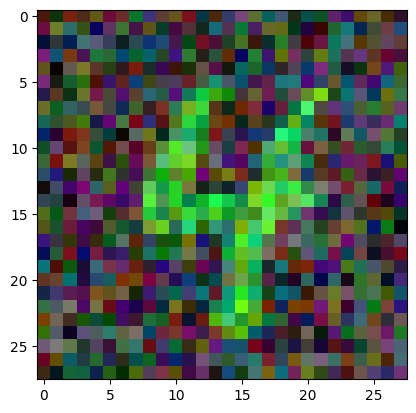

In [7]:
x, [y, c] = next(generate_data(x_test, y_test, batch_size=1))

print(y, colors[c[0]])
plt.imshow(x[0])

## Task 4: Create Model



In [8]:
# Now we will create model for this custom data set
# The Model has 2 task to do :
# 1. Recognize and Classify the Digit in image
# 2. Identify the prominent color in the image

In [9]:
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Add, Dense

input_layer = Input(shape=(28, 28, 3), name="Input_Layer")

conv_1 = Conv2D(32, 3, name="Conv_Layer_1")(input_layer)
act_1 = Activation("relu", name="Activ_Layer_1")(conv_1)
pool_1 = MaxPool2D(4, name="MaxPool_Layer_1")(act_1)
flat_1 =  Flatten(name="Flatten_Layer_1")(pool_1)

color = Dense(1, activation="sigmoid", name="color")(flat_1)

conv_2 = Conv2D(32, 3, padding="same", name="Conv_Layer_2")(act_1)
act_2 = Activation("relu", name="Activ_Layer_2")(conv_2)

conv_3 = Conv2D(32, 3, padding="same", name="Conv_Layer_3")(act_2)
add = Add(name="Add_Layer")([act_1, conv_3]) # Will add 2 Layers
act_3 = Activation("relu", name="Activ_Layer_3")(add)

pool_2 = MaxPool2D(4, name="MaxPool_Layer_2")(act_3)
flat_2 =  Flatten(name="Flatten_Layer_2")(pool_2)

digit = Dense(10, activation="softmax", name="digit")(flat_2)

2022-09-29 17:12:06.466620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 17:12:06.578014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-09-29 17:12:06.578073: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-09-29 17:12:06.580693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [10]:
# There will be 2 outputs (Color and Digit)
# and the digit output layer will be first because of the design of dataset generator
model = tf.keras.models.Model(input_layer, [digit, color])

model.compile(
    loss={
        "digit": "sparse_categorical_crossentropy",
        "color": "binary_crossentropy"
    },
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Layer (InputLayer)       [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 Conv_Layer_1 (Conv2D)          (None, 26, 26, 32)   896         ['Input_Layer[0][0]']            
                                                                                                  
 Activ_Layer_1 (Activation)     (None, 26, 26, 32)   0           ['Conv_Layer_1[0][0]']           
                                                                                                  
 Conv_Layer_2 (Conv2D)          (None, 26, 26, 32)   9248        ['Activ_Layer_1[0][0]']          
                                                                                              

In [11]:
# Plotting the model architecture
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Task 5 : Training the Model

In [12]:
# It is just a keras callback function which will just print model validation metrics
class Logger(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    digit_accuracy = logs.get('digit_accuracy')
    color_accuracy = logs.get('color_accuracy')
    val_digit_accuracy = logs.get('val_digit_accuracy')
    val_color_accuracy = logs.get('val_color_accuracy')
    print('='*30, epoch + 1, '='*30)
    print(f'digit_accuracy: {digit_accuracy:.2f}, color_accuracy: {color_accuracy:.2f}')
    print(f'val_digit_accuracy: {val_digit_accuracy:.2f}, val_color_accuracy: {val_color_accuracy:.2f}')
    print("\n\n")

In [13]:
# Generating the Custom Dataset
train_gen = generate_data(x_train, y_train)
test_gen = generate_data(x_test, y_test)

_ = model.fit(
    train_gen,
    validation_data=test_gen,
    steps_per_epoch=200,
    validation_steps=100,
    epochs=10,
    callbacks=[
        Logger(), # Our Custom Callback Function
        tf.keras.callbacks.TensorBoard(log_dir="./logs")
    ],
    verbose=True
)

Epoch 1/10
200/200 [==============================] - ETA: 0s - loss: 1.3482 - digit_loss: 1.1579 - color_loss: 0.1903 - digit_accuracy: 0.6044 - color_accuracy: 0.9833============================== 1 ==============================
digit_accuracy: 0.60, color_accuracy: 0.98
val_digit_accuracy: 0.87, val_color_accuracy: 1.00



200/200 [==============================] - 47s 211ms/step - loss: 1.3482 - digit_loss: 1.1579 - color_loss: 0.1903 - digit_accuracy: 0.6044 - color_accuracy: 0.9833 - val_loss: 0.4364 - val_digit_loss: 0.4179 - val_color_loss: 0.0185 - val_digit_accuracy: 0.8687 - val_color_accuracy: 1.0000
Epoch 2/10
200/200 [==============================] - ETA: 0s - loss: 0.3716 - digit_loss: 0.3606 - color_loss: 0.0109 - digit_accuracy: 0.8856 - color_accuracy: 1.0000============================== 2 ==============================
digit_accuracy: 0.89, color_accuracy: 1.00
val_digit_accuracy: 0.91, val_color_accuracy: 1.00



200/200 [==============================] - 45s 222

In [ ]:
%tensorboard --logdir logs

## Task 6: Final Prediction

In [15]:
def test_model(show=True):
    x, [y, c] = next(test)

    preds = model.predict(x)

    # for digit we are using np.argmax because the output is going to be probability distribution
    pred_digit = np.argmax(preds[0])
    
    # for color we just the probability if color is less than 0.5 then it is red else it is green
    pred_color = int(preds[1] > 0.5)
    
    gt_digit = int(y[0])
    gt_color = int(c[0])

    plt.imshow(x[0])

    if show:
        print(f'GT: {gt_digit}, {colors[gt_color]}')
        print(f'Pr: {pred_digit}, {colors[pred_color]}')
        plt.show()

    else:
        col = 'green' if gt_digit == pred_digit and gt_color == pred_color else 'red'
        plt.ylabel(f'GT: {gt_digit}, {colors[gt_color]}', color=col)
        plt.xlabel(f'Pr: {pred_digit}, {colors[pred_color]}', color=col)
        plt.xticks([])
        plt.yticks([])

test = generate_data(x_test, y_test, batch_size=1)

1/1 [==============================] - 0s 44ms/step
GT: 7, green
Pr: 7, green


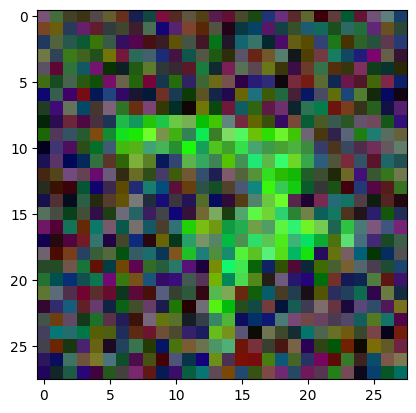

In [32]:
test_model()

1/1 [==============================] - 0s 39ms/step


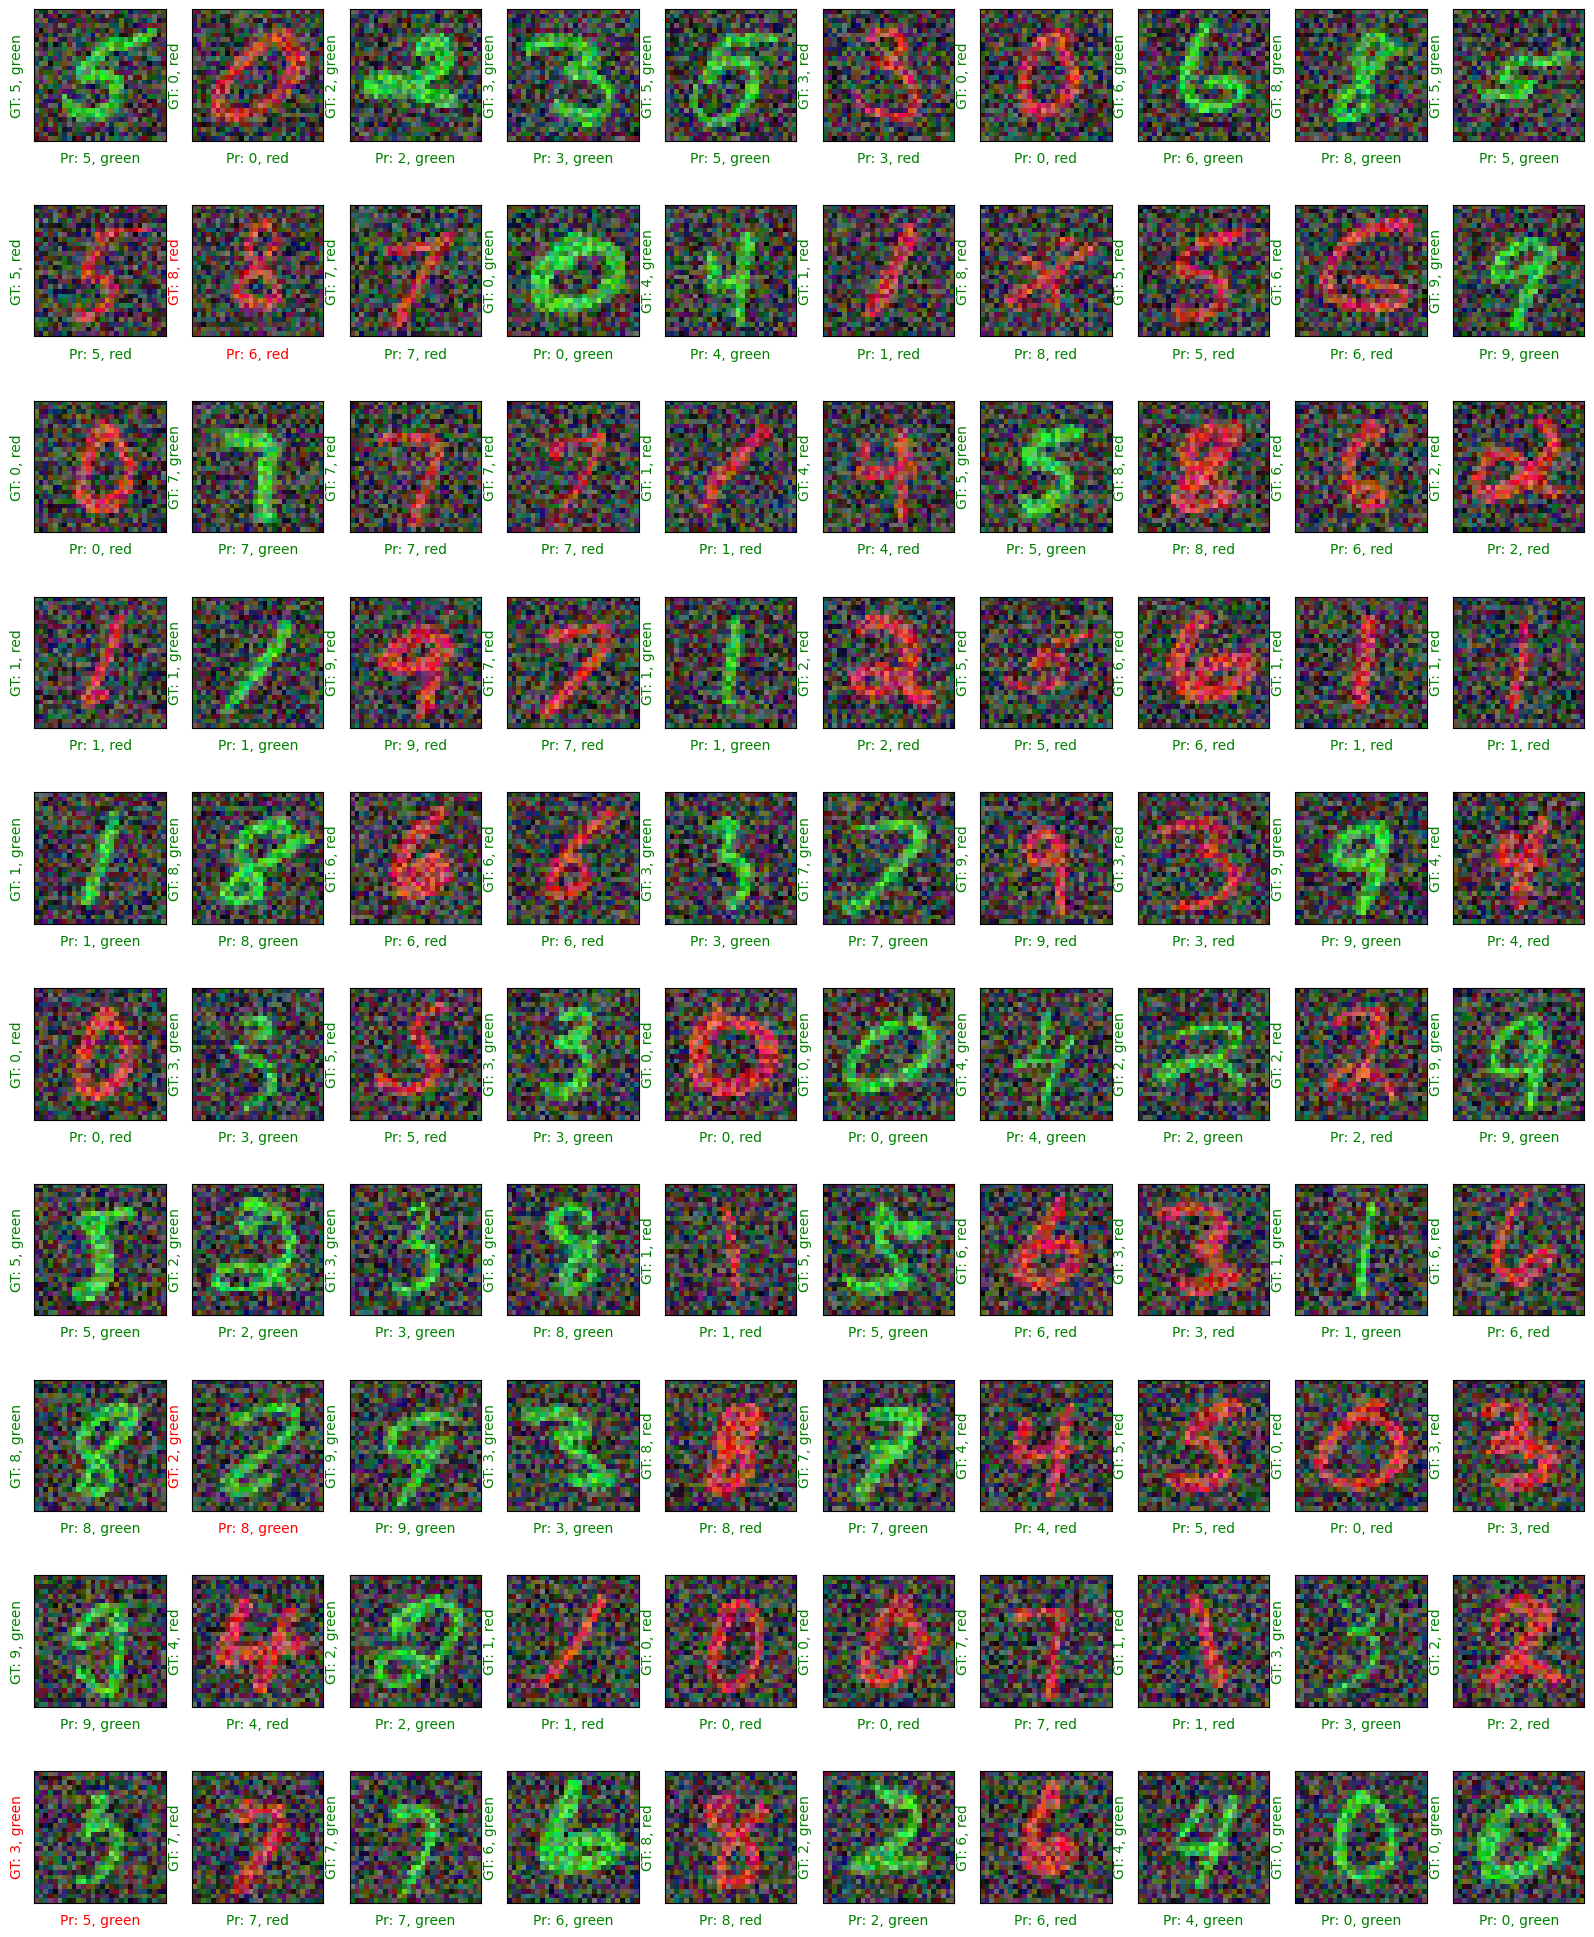

In [42]:
plt.figure(figsize=(20,25))
for i in range(100):
    plt.subplot(10, 10, i+1)
    test_model(show=False)
plt.show()